# TensorFlow Profiler: Profile model performance

## Overview

机器学习算法通常在计算上很昂贵。因此，量化机器学习应用程序的性能至关重要，以确保您运行最优化的模型版本。使用TensorFlow Profiler分析TensorFlow代码的执行。

## Setup

In [2]:
from datetime import datetime
from packaging import version

import os

In [3]:
!pip install -U tensorboard_plugin_profile

In [4]:
import tensorflow as tf

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.6.0


In [5]:
device_name = tf.test.gpu_device_name()
if not device_name:
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0Metal device set to: Apple M1



2022-04-28 09:57:36.174517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 09:57:36.174846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 使用 TensorBoard 回调训练图像分类模型

在本教程中，您将通过训练模型在MNIST数据集中对图像进行分类而获得的性能配置文件来探索TensorFlow Profiler的功能。

使用 TensorFlow datasets 导入训练数据并将其拆分为训练和测试集。

In [6]:
!pip install tensorflow_datasets

In [7]:
import tensorflow as tf
from tensorflow import keras

In [7]:
# (ds_train, ds_test), ds_info = tfds.load(
#     'mnist',
#     split=['train', 'test'],
#     shuffle_files=True,
#     as_supervised=True,
#     with_info=True,
# )

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")
x_train = x_train / 255.
x_test = x_test / 255.
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, 28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

2022-04-25 21:27:49.780183: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-25 21:27:49.780204: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


创建一个TensorBoard回调，以捕获 performance profiles 文件，并在训练模型时调用它。

In [9]:
# Create a TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

model.fit(x_train, 
          y_train,
          epochs=2,
          validation_data=(x_test, y_test),
          callbacks = [tboard_callback])

2022-04-25 21:27:49.826559: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-25 21:27:49.826565: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-25 21:27:49.826649: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/2
   1/1875 [..............................] - ETA: 4:57 - loss: 2.3253 - accuracy: 0.1250

2022-04-25 21:27:50.255143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-25 21:27:50.255357: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-25 21:27:50.345675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 551/1875 [=======>......................] - ETA: 3s - loss: 0.4238 - accuracy: 0.8843

2022-04-25 21:27:51.907339: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-25 21:27:51.907349: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-25 21:27:51.976458: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-25 21:27:51.978554: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-25 21:27:51.980839: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20220425-212749/train/plugins/profile/2022_04_25_21_27_51

2022-04-25 21:27:51.983123: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20220425-212749/train/plugins/profile/2022_04_25_21_27_51/Shawns.local.trace.json.gz
2022-04-25 21:27:51.984320: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20220425-212749/train/plugins/profile/20

1873/1875 [============================>.] - ETA: 0s - loss: 0.2542 - accuracy: 0.9285WARNING:tensorflow:Model was constructed with shape (None, 1, 28, 28) for input KerasTensor(type_spec=TensorSpec(shape=(None, 1, 28, 28), dtype=tf.float32, name='flatten_input'), name='flatten_input', description="created by layer 'flatten_input'"), but it was called on an input with incompatible shape (None, 28, 28).


2022-04-25 21:27:56.116691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 7s 3ms/step - loss: 0.2540 - accuracy: 0.9285 - val_loss: 0.1379 - val_accuracy: 0.9593
Epoch 2/2
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1090 - accuracy: 0.9676 - val_loss: 0.0966 - val_accuracy: 0.9720


## Use the TensorFlow Profiler to profile model training performance

TensorFlow Profiler 嵌入在 TensorBoard 中。使用 Colab 魔法加载 TensorBoard 并启动它。通过导航到 `Profile` 选项卡来查看 performance profiles 文件。

In [9]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

该模型的 performance profile 文件与下图相似。

In [10]:
# Launch TensorBoard and navigate to the Profile tab to view performance profile
%tensorboard --logdir=logs

**Profile** tab 打开一个 Overview 页面， 其展示你的模型表现的 high-level summary。 看一下右侧的 Step-time Graph, 你可以看到模型的输入边界(例如， 它花费大量的时间在 data input pipleline)。Overview 页面给你一些接下来优化模型表现地建议。

为了理解 input pipeline 中出现的性能瓶颈， 选择左侧 **Tools** 中 **Trace Viewer**。 Trace Viewer 向你展示在 Profiling 期间， CPU 和 GPU 出现的不同事件。

Trance Viewer 在垂直轴上展现多个事件组。 每个事件组有多个水平 tracks， 填满了 trace events。 track 是在一个线程或一个 GPU 流的 event 时间线。 单个事件在时间线 tracks 上是彩色的矩形块。 事件从左向右移动。 使用键盘快捷键 `W`(zoom in), `S` (zoom out), `A`(scroll left), 和 `D`(scroll right)。

一个单个矩形表示一个 trace 事件。 在 floating tool bar 中选择鼠标光标(或者使用键盘快捷键 `1`) 并且 点积 trace event 分析它。 这回展示关于该事件的信息， 比如开始时间和持续时间。

除了点击， 你可以拖拽鼠标选择 trace events 的组。 这会给你一组沿着一个 event summary 的 events 列表。使用 `M` 健来测量所选事件持续的时间。

trace event 收集来自于：

- **CPU**： CPU 时间在一个叫做 `/host:CPU` 的事件组下展示。 每个 track 表示一个在 CPU 的线程。 CPU events 包括多个 input pipeline events, GPU operation(op) scheduling events, CPU op execution events etc.
- **GPU**： GPU 在前缀为 `/device:GPU` 的事件组下展示。 GPU上每个事件组展示为一个流。

## Debug performance bottlenecks

使用 Trace Viewer 定位输入 pipeline 的性能瓶颈。下图展示了 performance profile 的截图

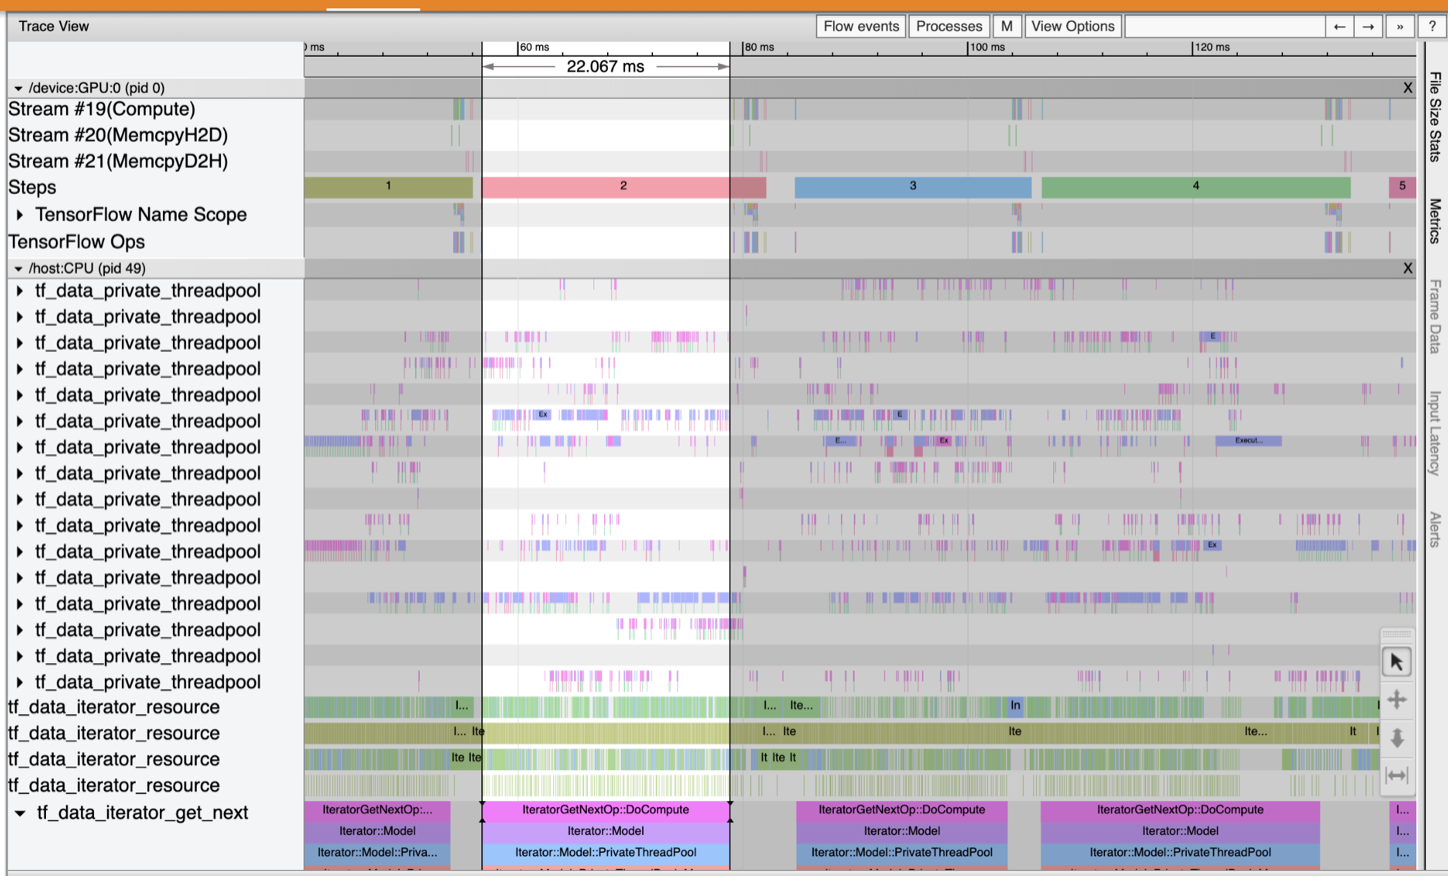

从 event traces 中可以看到，  在 `tf_data_iterator_get_next` op 运行在 CPU 上时 GPU 并不活跃。 这个 op 负责为处理输入数据并将其送入 GPU 训练。 

使用 `tf.data` API 优化输入 pipeline。 在这个例子中， 让我们缓存训练数据集并且提前将数据取出以确保总有GPU可处理的数据。 